# Scooby Evaluator

## General Imports

In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import os

import numpy as np
import pandas as pd
import scipy
import torch
import tqdm
from accelerate import Accelerator
from peft import LoraConfig, get_peft_model
import scanpy as sc

from torch.utils.data import DataLoader

from enformer_pytorch.data import GenomeIntervalDataset

from scooby.modeling import Scooby

from borzoi_pytorch.config_borzoi import BorzoiConfig
from scooby.data import onTheFlyCountDataset, onTheFlyPseudobulkDataset
from scooby.utils.utils import fix_rev_comp_multiome, undo_squashed_scale, get_cell_count_pred, get_gene_slice_and_strand, get_pseudobulk_count_pred

In [65]:
data_path = '/data/ceph/hdd/project/node_08/QNA/scborzoi/submission_data/scooby_training_data/'

## scooby

### Functions for Pearson correlation

In [66]:
def stack_and_pearson(x,y):
    return torch.corrcoef(torch.stack([x,y]))[0,1]
batched_pearson = torch.vmap(stack_and_pearson, chunk_size=1)

def predict(model, seqs, conv_weights, conv_biases, bins_to_predict):
    out = model.forward_sequence_w_convs(seqs, conv_weights, conv_biases, bins_to_predict)
    out = torch.log1p(torch.sum(out, dim = -2))
    return out

In [67]:
def predict_pseudo(model, seqs, seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None):
    # assert bs == 1
    with torch.no_grad():
        with torch.autocast("cuda"):
            outputs = model.forward_sequence_w_convs(seqs, conv_weights, conv_biases, bins_to_predict = bins_to_predict)
            outputs = torch.log1p(torch.sum(outputs, dim = -2))
    return outputs

### Load the model

In [68]:
accelerator = Accelerator(step_scheduler_with_optimizer = False)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


#### Option 1: Load pretrained scooby from the hub

#### Option 2: Load self-trained scooby checkpoint, un-lora it, and save it

In [69]:
context_length  = 524288

In [113]:
import safetensors
from scooby.utils.utils import get_lora
#Initialize the config
config = BorzoiConfig.from_pretrained("johahi/flashzoi-replicate-0")
csb = Scooby.from_pretrained(
        'johahi/flashzoi-replicate-0',
        config = config,
        cell_emb_dim=14,
        embedding_dim=1920,
        n_tracks=1,
        return_center_bins_only=True,
        disable_cache=False,
        use_transform_borzoi_emb=False,
        count_only=True
    )

# we have to make the lora version, load the weights, and merge the lora weights back into scooby
#csb = get_lora(csb, train=False)
print (safetensors.torch.load_model(csb,'/s/project/QNA/borzoi_saved_models/scooby_epoch_47_0_scooby_count_onlyfullFT/model.safetensors')) 
#csb = csb.merge_and_unload()

# If you want to save the model to load it quicker next time
#csb.save_pretrained('test_scooby_checkpoint')
# can be then loaded with 
# scooby = Scooby.from_pretrained('test_scooby_checkpoint', cell...)

Some weights of Scooby were not initialized from the model checkpoint at johahi/flashzoi-replicate-0 and are newly initialized: ['cell_state_to_conv.0.bias', 'cell_state_to_conv.0.weight', 'cell_state_to_conv.2.bias', 'cell_state_to_conv.2.weight', 'cell_state_to_conv.5.bias', 'cell_state_to_conv.5.weight', 'cell_state_to_conv.8.bias', 'cell_state_to_conv.8.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(set(), [])


### Specify genome

In [114]:
gtf_file = os.path.join(data_path, "gencode.v32.annotation.sorted.gtf.gz")
fasta_file = os.path.join(data_path, 'genome_human.fa')
bed_file = os.path.join(data_path, 'sequences.bed')

In [115]:
data_path

'/data/ceph/hdd/project/node_08/QNA/scborzoi/submission_data/scooby_training_data/'

### Load neighbors and embedding

In [116]:
base_path = os.path.join(data_path, 'snapatac', 'pseudobulks_fixed/')

In [117]:
sample = 'merged'
neighbors = scipy.sparse.load_npz(os.path.join(data_path, 'no_neighbors.npz'))
embedding = pd.read_parquet(os.path.join(data_path, 'embedding_no_val_genes_new.pq'))

In [118]:
cell_type_index = pd.read_parquet(os.path.join(data_path,  'celltype_fixed.pq'))
cell_type_index['size'] = cell_type_index['cellindex'].apply(lambda x: len(x))

In [119]:
cell_type_index['celltype'] = cell_type_index['celltype'].str.replace(' ', '_').replace(r"G/M_prog", "G+M_prog").replace("MK/E_prog", "MK+E_prog") #+ '_filtered'
cell_type_index = cell_type_index.sort_values('celltype')

## Eval on Val

### Sequence dataloader 

This only loads the sequences in the right order

In [120]:
gtf_file = f"/data/ceph/hdd/project/node_08/QNA/scborzoi/submission_data/gencode.v32.annotation.gtf"

In [121]:
from scooby.utils.transcriptome import Transcriptome

In [136]:
transcriptome = Transcriptome(gtf_file)

In [137]:
import polars as pl
filter_val = lambda df: df.filter(True)#
val_ds = GenomeIntervalDataset(
    bed_file = '/s/project/QNA/seq2space/genes_tsscentered_human_with_fold_test_only_1.bed', #os.path.join(data_path, 'test_gene_sequences.csv'),
    fasta_file = fasta_file,
    filter_df_fn = lambda df: df.filter((pl.col('column_2') >=0)), 
    return_seq_indices = False,
    shift_augs = (0,0),
    rc_aug = False,
    return_augs = True,
    context_length = context_length,
    chr_bed_to_fasta_map = {}
)
len(val_ds)

2546

In [138]:
val_ds

In [139]:
adata_counts_path = "/data/ceph/hdd/project/node_08/QNA/scborzoi/submission_data/bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed_GEX.h5ad"
adata_counts = sc.read_h5ad(adata_counts_path)

In [140]:
adata_counts_temp = sc.pp.normalize_total(adata_counts, layer="counts", copy=True)
adata_aggregated = sc.get.aggregate(adata_counts_temp, by="l2_cell_type", func="sum", layer="counts")

In [141]:
adata_aggregated.obs_names = adata_aggregated.obs_names.str.replace(' ', '_').str.replace(r"G/M_prog", "G+M_prog").str.replace("MK/E_prog", "MK+E_prog")

In [142]:
val_dataset = onTheFlyCountDataset(
    adata_count=adata_counts, 
    embedding=embedding,
    ds=val_ds,
    random_cells = False,
    cells_to_run = None, 
    gtf_file=gtf_file)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, num_workers = 1)
csb, val_loader = accelerator.prepare(csb, val_loader)

In [143]:
len(val_dataset)

2546

### Target dataloader on bigwig pseudobulk files

In [144]:
base_path = "/data/ceph/hdd/project/node_08/QNA/scborzoi/submission_data/scooby_training_data/pseudobulks/"

In [145]:
val_dataset_targets = onTheFlyPseudobulkDataset(
    cell_types = cell_type_index['celltype'].values,
    ds = val_ds, 
    base_path = base_path, 
)

### Get cell conv_weights for all cells

In [146]:
csb.eval()
cell_indices  = []
size_factors_per_ct = []
for _, row in tqdm.tqdm(cell_type_index.iterrows(),disable = True):
    cell_indices.append(
        torch.from_numpy(
            np.vstack(
                embedding.iloc[row['cellindex']]['embedding'].values # gets embeddings of all cells of the cell type
                )
            ).unsqueeze(0)
        ) # prep cell_embeddings

# get conv weights and biases for all cells sorted by cell type in a list
cell_emb_conv_weights_and_biases = []
for cell_emb_idx in tqdm.tqdm(cell_indices, disable = True):
    cell_emb_idx = cell_emb_idx.cuda()
    conv_weights, conv_biases = csb.forward_cell_embs_only(cell_emb_idx)
    cell_emb_conv_weights_and_biases.append((conv_weights.to(torch.float16), conv_biases.to(torch.float16)))


### Get counts over exons

In [147]:
device = torch.device("cuda")

#### Get full predicted GEX

#### Get pseudobulk GEX

In [176]:
num_neighbors = 1

all_outputs, all_targets, all_targets_true = [], [], []
val_dataset_target_loader = iter(DataLoader(val_dataset_targets, batch_size=1, shuffle = False, num_workers = 4))
genes = []
# iterate over all gene sequences
for i,x in tqdm.tqdm(enumerate(val_loader), disable = False, total=len(val_dataset)):
    gene_slice, strand = get_gene_slice_and_strand(transcriptome, val_dataset_targets.genome_ds.df[i, 'column_4'], val_dataset_targets.genome_ds.df[i, 'column_2'], span = False)
    # continue

    ### switch ot gene_slices_temp
    targets = (next(val_dataset_target_loader)[2]).float().cuda()
    if len(gene_slice) == 0:
        continue
    genes.append(val_dataset_targets.genome_ds.df[i, 'column_4'])
    stacked_outputs = []
    if len(x) == 5:
        inputs, rc_augs, targets_true, cell_emb_idx, gene_slices_temp = x 
        gene_slices_temp = gene_slices_temp[0]
    else:
        inputs, rc_augs, targets_true, cell_emb_idx = x 
        gene_slices_temp = None
    inputs = inputs.permute(0, 2, 1).to(device, non_blocking=True)
    with torch.autocast("cuda"):
        stacked_outputs = get_pseudobulk_count_pred(csb, inputs, cell_emb_conv_weights_and_biases, gene_slice=gene_slices_temp, 
                    predict=predict_pseudo, model_type="count", 
                    strand=None, clip_soft=5, process_counts=True)
    all_outputs.append(stacked_outputs)
    if strand == '+':
        all_targets.append(undo_squashed_scale(targets[0, gene_slices_temp, ::2], clip_soft=384).sum(axis=0).detach().clone().cpu().squeeze())
    elif strand == '-':
        all_targets.append(undo_squashed_scale(targets[0, gene_slices_temp, 1::2], clip_soft=384).sum(axis=0).detach().clone().cpu().squeeze())
    all_targets_true.append(targets_true.detach().clone().cpu().squeeze())
all_outputs, all_targets, all_targets_true = torch.vstack(all_outputs).clone().numpy(force=True),torch.vstack(all_targets).clone().numpy(force=True), torch.vstack(all_targets_true).clone().numpy(force=True)

100%|██████████| 2546/2546 [05:23<00:00,  7.88it/s]


In [177]:
all_targets_true = adata_aggregated[cell_type_index.celltype.tolist(), genes].layers["sum"].T.copy()

In [178]:
all_outputs.shape

(2546, 21)

In [179]:
all_targets_true.shape

(2546, 21)

In [180]:
np.median(all_outputs)

1328.3148

Text(0, 0.5, 'Target')

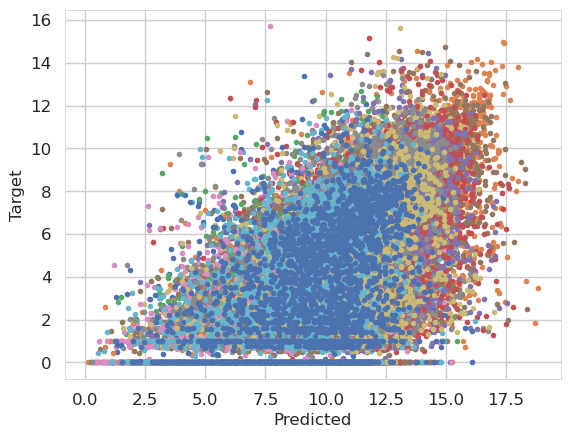

In [181]:
import matplotlib.pyplot as plt
plt.plot(np.log2(all_outputs + 1), np.log2(all_targets+1), '.')
plt.xlabel('Predicted')
plt.ylabel('Target')

Text(0, 0.5, 'Target')

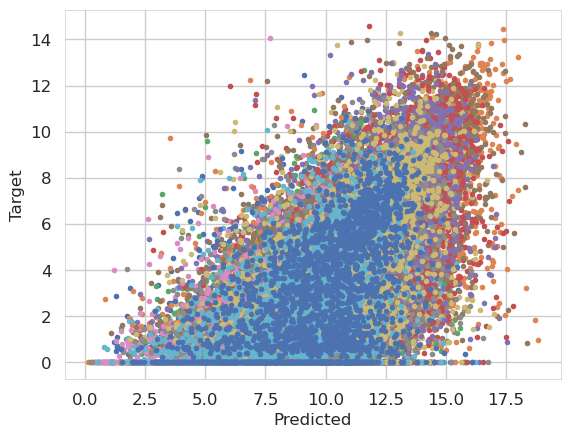

In [182]:
import matplotlib.pyplot as plt
plt.plot(np.log2(all_outputs + 1), np.log2(all_targets_true + 1), '.')
plt.xlabel('Predicted')
plt.ylabel('Target')

In [183]:
spearmanr = [
    scipy.stats.spearmanr(np.log2(all_outputs[:, i] + 1), 
                          np.log2(all_targets[:, i] + 1))[0] for i in range(all_outputs.shape[1])
]
pearsonr =  [
    scipy.stats.pearsonr (np.log2(all_outputs[:, i] + 1), 
                          np.log2(all_targets[:, i] + 1))[0] for i in range(all_outputs.shape[1])]

In [184]:
np.mean(pearsonr), np.median(pearsonr) # np.mean(pearsonr), np.median(pearsonr) with normos (0.8695861071966647, 0.8775566542956221)

(0.5262881304268248, 0.5248083626215657)

In [185]:
spearmanr_true = [
    scipy.stats.spearmanr(np.log2(all_outputs[:, i] + 1), 
                          np.log2(all_targets_true[:, i]) + 1)[0] for i in range(all_outputs.shape[1])
]
pearsonr_true =  [
    scipy.stats.pearsonr (np.log2(all_outputs[:, i] + 1), 
                          np.log2(all_targets_true[:, i] + 1))[0] for i in range(all_outputs.shape[1])]

/scratch/tmp/l_minaeva/ipykernel_1475058/3311263851.py:3: RuntimeWarning: divide by zero encountered in log2
  np.log2(all_targets_true[:, i]) + 1)[0] for i in range(all_outputs.shape[1])


In [186]:
np.mean(pearsonr_true), np.median(pearsonr_true)

(0.5534868886120275, 0.5564686715995764)

Text(0.5, 1.0, 'Count, across gene comparison')

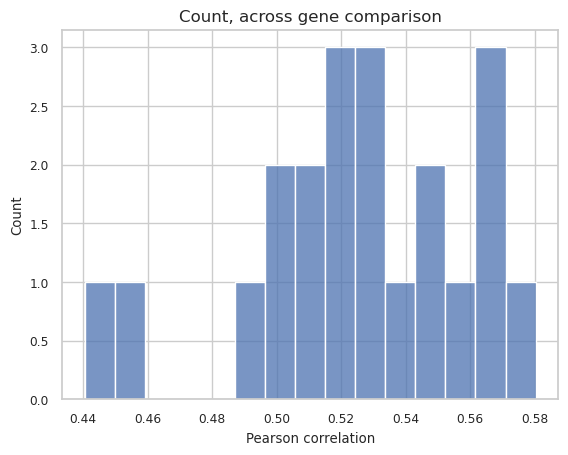

In [187]:
import seaborn as sns
sns.set_theme(style="whitegrid",  font_scale=0.8)
sns.histplot(pearsonr, bins = 15)
plt.xlabel('Pearson correlation')
plt.title('Count, across gene comparison',  size = 12)

Text(0.5, 1.0, 'Count, across gene comparison')

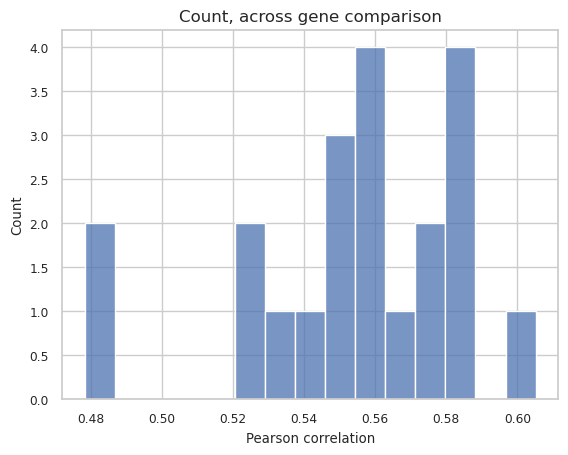

In [188]:
import seaborn as sns
sns.set_theme(style="whitegrid",  font_scale=0.8)
sns.histplot(pearsonr_true, bins = 15)
plt.xlabel('Pearson correlation')
plt.title('Count, across gene comparison',  size = 12)

In [189]:
# log2(x+1)
counts_predicted_log = np.log2(pd.DataFrame(all_outputs) + 1)  #pd.read_parquet("/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval/count_predicted_log.parquet")# np.log2(pd.DataFrame(all_outputs) + 1) 
#counts_predicted_log = counts_predicted_log.drop(16, axis = 1) #remove other myloids?
# substract mean per gene across all cell types
counts_predicted_log = counts_predicted_log - counts_predicted_log.mean(axis=0)

#substract mean per cell type across all genes
counts_predicted_log = counts_predicted_log.subtract(counts_predicted_log.mean(axis=1), axis=0)
counts_target_log =np.log2(pd.DataFrame(all_targets) + 1)# pd.read_parquet("/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval/count_target_log.parquet")# np.log2(pd.DataFrame(all_targets) + 1)
#counts_target_log = counts_target_log.drop(16, axis = 1) #remove other myloids?
counts_target_log = counts_target_log - counts_target_log.mean(axis=0)

counts_target_log = counts_target_log.subtract(counts_target_log.mean(axis=1), axis=0)

In [190]:
import matplotlib as mp
font_size=  12
mp.rcParams['axes.labelsize'] = font_size
mp.rcParams['axes.linewidth'] = font_size / 24.
mp.rcParams['axes.titlesize'] = font_size
mp.rcParams['legend.fontsize'] = font_size
mp.rcParams['xtick.labelsize'] = font_size
mp.rcParams['ytick.labelsize'] = font_size

0.3337702442135559


Text(0.5, 0, 'Predicted')

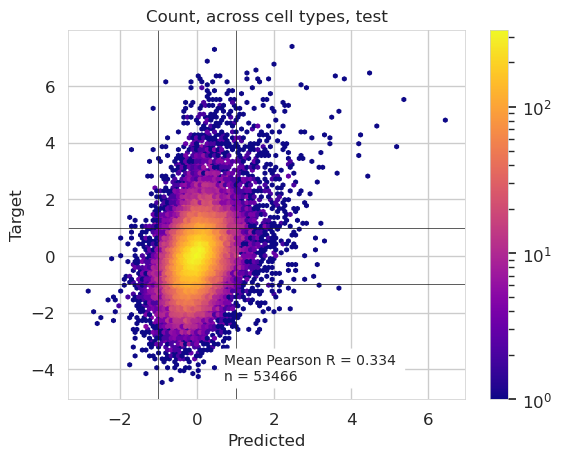

In [191]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
ax = plt.hexbin(x=counts_predicted_log.values.ravel(), y=counts_target_log.values.ravel(), mincnt=1, cmap='plasma', norm=LogNorm())
plt.axvline(1, c='k', linewidth = font_size/24)
plt.axvline(-1,c='k', linewidth = font_size/24)
plt.axhline(1,c='k', linewidth = font_size/24)
plt.axhline(-1,c='k', linewidth = font_size/24)
plt.colorbar()
plt.ylabel('Target')
plt.title('Count, across cell types, test')
p=scipy.stats.pearsonr(counts_predicted_log.values.ravel(), counts_target_log.values.ravel())[0]
# plt.text(2.5,-5, f"Pearson corr.: {np.round(p, 3)}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
plt.text(.7,-4.4, f"Mean " + r"Pearson R"+ f" = {p:.3f} \nn = {len(counts_predicted_log.values.ravel())}", bbox=dict(facecolor='white', edgecolor='white', boxstyle='round'), fontdict={'size' : 10})
print(p)
plt.xlabel('Predicted')
#plt.savefig("Fig2E.svg",bbox_inches="tight")

In [192]:
# log2(x+1)
counts_predicted_log = np.log2(pd.DataFrame(all_outputs) + 1)  #pd.read_parquet("/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval/count_predicted_log.parquet")# np.log2(pd.DataFrame(all_outputs) + 1) 
#counts_predicted_log = counts_predicted_log.drop(16, axis = 1) #remove other myloids?
# substract mean per gene across all cell types
counts_predicted_log = counts_predicted_log - counts_predicted_log.mean(axis=0)

#substract mean per cell type across all genes
counts_predicted_log = counts_predicted_log.subtract(counts_predicted_log.mean(axis=1), axis=0)
counts_target_log = np.log2(pd.DataFrame(all_targets_true) + 1)# pd.read_parquet("/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval/count_target_log.parquet")# np.log2(pd.DataFrame(all_targets_true_true) + 1)
#counts_target_log = counts_target_log.drop(16, axis = 1) #remove other myloids?
counts_target_log = counts_target_log - counts_target_log.mean(axis=0)

counts_target_log = counts_target_log.subtract(counts_target_log.mean(axis=1), axis=0)

0.3233376422734276


Text(0.5, 0, 'Predicted')

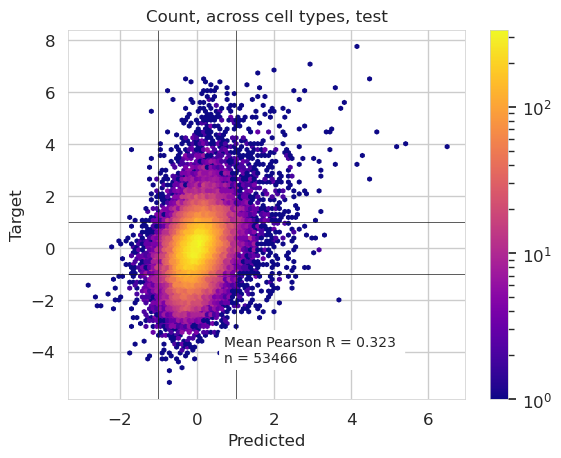

In [193]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
ax = plt.hexbin(x=counts_predicted_log.values.ravel(), y=counts_target_log.values.ravel(), mincnt=1, cmap='plasma', norm=LogNorm())
plt.axvline(1, c='k', linewidth = font_size/24)
plt.axvline(-1,c='k', linewidth = font_size/24)
plt.axhline(1,c='k', linewidth = font_size/24)
plt.axhline(-1,c='k', linewidth = font_size/24)
plt.colorbar()
plt.ylabel('Target')
plt.title('Count, across cell types, test')
p=scipy.stats.pearsonr(counts_predicted_log.values.ravel(), counts_target_log.values.ravel())[0]
# plt.text(2.5,-5, f"Pearson corr.: {np.round(p, 3)}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
plt.text(.7,-4.4, f"Mean " + r"Pearson R"+ f" = {p:.3f} \nn = {len(counts_predicted_log.values.ravel())}", bbox=dict(facecolor='white', edgecolor='white', boxstyle='round'), fontdict={'size' : 10})
print(p)
plt.xlabel('Predicted')
#plt.savefig("Fig2E.svg",bbox_inches="tight")